**1. Импортируем библиотеки и читаем csv**

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/invest_db.csv", sep=";", decimal=",")

**2. Чистим данные**

In [131]:
df.head()

,id,date,age,education_level_cd,marital_status_cd,children_cnt,monthly_income_amt,invest_utilization_dt,forts_flg,margin_status_flg,...,portf_fnd_amt,portf_opt_amt,portf_ore_amt,ccr_balance_amt,cor_balance_amt,lon_balance_amt,posts,comments,reacts,reads
0,1479787897,2024-04-20,33,NaN,UNM,0.0,31272.0,2023-09-13,1,0,...,428.0,0.0,0.0,-11298.0,541.0,0.0,0.0,0.0,0.0,0.0
1,601760063,2024-02-01,29,GRD,UNM,0.0,6284.0,2021-03-29,0,0,...,23.0,0.0,0.0,NaN,8115.0,0.0,0.0,0.0,0.0,0.0
2,61175329,2024-02-10,38,SCH,MAR,0.0,1904.0,2023-12-05,1,0,...,193.0,0.0,0.0,0.0,25.0,NaN,0.0,0.0,0.0,2.0
3,1411700618,2024-03-05,64,NaN,NaN,0.0,NaN,2021-09-16,0,0,...,0.0,0.0,0.0,NaN,65.0,NaN,0.0,0.0,0.0,0.0
4,2096755145,2024-02-10,31,NaN,UNM,0.0,NaN,2022-03-01,0,0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [132]:
df.shape

(458370, 51)

In [133]:
# Преобразуем даты
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["invest_utilization_dt"] = pd.to_datetime(df["invest_utilization_dt"], errors="coerce")

In [134]:
# Посмотрим дубликаты
# Полные дубликаты
rows_duplicated = df.duplicated().sum()
print(f"Кол-во полных дубликатов: {rows_duplicated}")

# Дубликаты по id и date
id_date_duplicated = df.duplicated(subset=['id','date']).sum()
print(f"Кол-во частичных дубликатов: {id_date_duplicated}")

Кол-во полных дубликатов: 0
Кол-во частичных дубликатов: 0


In [135]:
# Посмотрим уникальные значения
users_amt = df["id"].nunique()
print(f"Кол-во уникальных пользователей: {users_amt}")

date_amt = df["date"].nunique()
print(f"Кол-во уникальных дат: {date_amt}")
print(f"Набор дат с {df["date"].min()} до {df["date"].max()}")

Кол-во уникальных пользователей: 5093
Кол-во уникальных дат: 90
Набор дат с 2024-02-01 00:00:00 до 2024-04-30 00:00:00


In [136]:
# Посмотрим на пропуски
na = df.isnull().sum()
na_percent = (df.isnull().mean() * 100).round(2)
print("Кол-во пропущенных значений в столбце и их доля")
for i in range(len(na)):
  if na.iloc[i] != 0:
    print(f"{na.index[i]} = {na.iloc[i]} пропусков, {na_percent.iloc[i]}%")

Кол-во пропущенных значений в столбце и их доля
education_level_cd = 224910 пропусков, 49.07%
marital_status_cd = 191340 пропусков, 41.74%
children_cnt = 48060 пропусков, 10.48%
monthly_income_amt = 103230 пропусков, 22.52%
ccr_balance_amt = 167028 пропусков, 36.44%
cor_balance_amt = 1062 пропусков, 0.23%
lon_balance_amt = 309867 пропусков, 67.6%
posts = 19320 пропусков, 4.21%
comments = 19320 пропусков, 4.21%
reacts = 19320 пропусков, 4.21%
reads = 19320 пропусков, 4.21%


In [137]:
# Проверим на подозрительные значения
print(df[df["in_payment_rub_amt"] < 0].shape)
print(df[df["out_payment_rub_amt"] < 0].shape)
print(df[df["uncovered_position_amt"] > 0].shape)

# Убираем непокрытые положительные позиции
df.drop(df[df["uncovered_position_amt"] > 0].index, inplace=True)

(0, 51)
(0, 51)
(883, 51)


In [138]:
df['id'].nunique()

5091

**3. Вводим доп столбцы и подготавливаем данные**

In [139]:
df.columns

Index(['id', 'date', 'age', 'education_level_cd', 'marital_status_cd',
       'children_cnt', 'monthly_income_amt', 'invest_utilization_dt',
       'forts_flg', 'margin_status_flg', 'qualified_investor_flg',
       'in_payment_rub_amt', 'out_payment_rub_amt', 'uncovered_position_amt',
       'turnover_rus_bon_amt', 'turnover_rus_sec_amt', 'turnover_forts_amt',
       'turnover_cur_amt', 'turnover_etf_amt', 'turnover_fnd_amt',
       'turnover_opt_amt', 'turnover_ore_prc_amt', 'turnover_ore_sel_amt',
       'turnover_tracking_amt', 'trade_order_rus_sec_cnt',
       'trade_order_rus_bon_cnt', 'trade_order_forts_cnt',
       'trade_order_cur_cnt', 'trade_order_etf_cnt', 'trade_order_fnd_cnt',
       'trade_order_opt_cnt', 'trade_order_ore_prc_cnt',
       'trade_order_ore_sel_cnt', 'trade_order_tracking_cnt',
       'portf_total_amt', 'portf_mex_amt', 'portf_rus_sec_amt',
       'portf_rus_bon_amt', 'initial_margin_amt', 'portf_cur_amt',
       'portf_etf_amt', 'portf_fnd_amt', 'portf_opt

In [140]:
# Торговая активность (оборот)
df["turnover_total_amt"] = df[['turnover_rus_bon_amt', 'turnover_rus_sec_amt', 'turnover_forts_amt',
       'turnover_cur_amt', 'turnover_etf_amt', 'turnover_fnd_amt',
       'turnover_opt_amt', 'turnover_ore_prc_amt', 'turnover_ore_sel_amt',
       'turnover_tracking_amt']].sum(axis=1)

# Сделки
df['trade_total_amt'] = df[['trade_order_rus_sec_cnt',
       'trade_order_rus_bon_cnt', 'trade_order_forts_cnt',
       'trade_order_cur_cnt', 'trade_order_etf_cnt', 'trade_order_fnd_cnt',
       'trade_order_opt_cnt', 'trade_order_ore_prc_cnt',
       'trade_order_ore_sel_cnt', 'trade_order_tracking_cnt']].sum(axis=1)

In [141]:
# Активности
# "Финансовая" активность (1/0)
df["activity"] = ((df['turnover_total_amt'] > 0) | (df['trade_total_amt'] > 0)).astype(int)

# Социальная активность
df["social_activity"] = ((df["posts"] > 0) | (df["comments"] > 0) | (df["reacts"] > 0)).astype(int)

In [142]:
# Группировки по пользователю
user_df = df.groupby('id').agg(age=('age', "max"), education_level_cd=('education_level_cd',"first"),
                            marital_status_cd=('marital_status_cd',"first"), children_cnt=('children_cnt',"first"),
                            monthly_income_amt=("monthly_income_amt", "mean"), invest_utilization_dt=("invest_utilization_dt", "min"),
                            in_payment_rub_amt=('in_payment_rub_amt',"sum"), out_payment_rub_amt=('out_payment_rub_amt',"sum"),
                            turnover_total_amt=('turnover_total_amt',"sum"), trade_total_amt=('trade_total_amt',"sum"),
                            activity=('activity',"mean"), social_activity=('social_activity',"mean"),
                            margin_status_flg=("margin_status_flg", "max"), forts_flg=("forts_flg", "max"),
                            qualified_investor_flg=("qualified_investor_flg", "max"), portf_total_amt=("portf_total_amt", "mean"),
                            posts=("posts", "sum"), comments=("comments", "sum"),
                            reacts=("reacts", "sum"), reads=("reads", "sum")).reset_index()
user_df.head()

,id,age,education_level_cd,marital_status_cd,children_cnt,monthly_income_amt,invest_utilization_dt,in_payment_rub_amt,out_payment_rub_amt,turnover_total_amt,...,activity,social_activity,margin_status_flg,forts_flg,qualified_investor_flg,portf_total_amt,posts,comments,reacts,reads
0,42390,36,SCH,DIV,1.0,NaN,2023-11-28,835.0,10277.0,195948.0,...,0.400000,0.000000,1,1,0,7566.066667,0.0,0.0,0.0,118.0
1,129326,37,SCH,MAR,0.0,5181.388889,2023-02-06,43031.0,36057.0,2690320.0,...,0.900000,0.055556,1,1,1,3911.444444,0.0,5.0,3.0,10307.0
2,185930,64,GRD,MAR,0.0,2712.800000,2023-12-22,0.0,0.0,2813.0,...,0.588889,0.000000,0,0,0,269.544444,0.0,0.0,0.0,0.0
3,404940,61,None,None,0.0,1587.766667,2023-03-07,0.0,0.0,38351.0,...,0.588889,0.000000,0,0,0,18932.633333,0.0,0.0,0.0,0.0
4,1035537,40,None,None,0.0,NaN,2022-08-11,237.0,0.0,18438.0,...,0.300000,0.000000,0,0,0,1014.900000,0.0,0.0,0.0,0.0


In [143]:
user_df["activity"] = user_df["activity"].round(2)
user_df["social_activity"] = user_df["social_activity"].round(2)
user_df["monthly_income_amt"] = user_df["monthly_income_amt"].round(2)
user_df["portf_total_amt"] = user_df["portf_total_amt"].round(2)

In [144]:
# Делаем df с группровкой по дате
daily_df = df.groupby('date').agg(in_payment_rub_amt=('in_payment_rub_amt',"sum"), out_payment_rub_amt=('out_payment_rub_amt',"sum"),
                               turnover_total_amt=('turnover_total_amt',"sum"), trade_total_amt=('trade_total_amt',"sum"),
                               activity=('activity',"mean"), social_activity=('social_activity',"mean")).reset_index()
daily_df["activity"] = daily_df["activity"].round(2)
daily_df["social_activity"] = daily_df["social_activity"].round(2)

In [145]:
# Добавим в новые df cashflow (разность in out)
user_df["cashflow"] = user_df["in_payment_rub_amt"] - user_df["out_payment_rub_amt"]
daily_df["cashflow"] = daily_df["in_payment_rub_amt"] - daily_df["out_payment_rub_amt"]

Насчет выбросов - ситуация неоднозначная. В финансовых продуктах большие значение не всегда про шум, возможно это крупные клиенты и исключение таких данных может быть некорректным решением.

**4. Базовые графики**

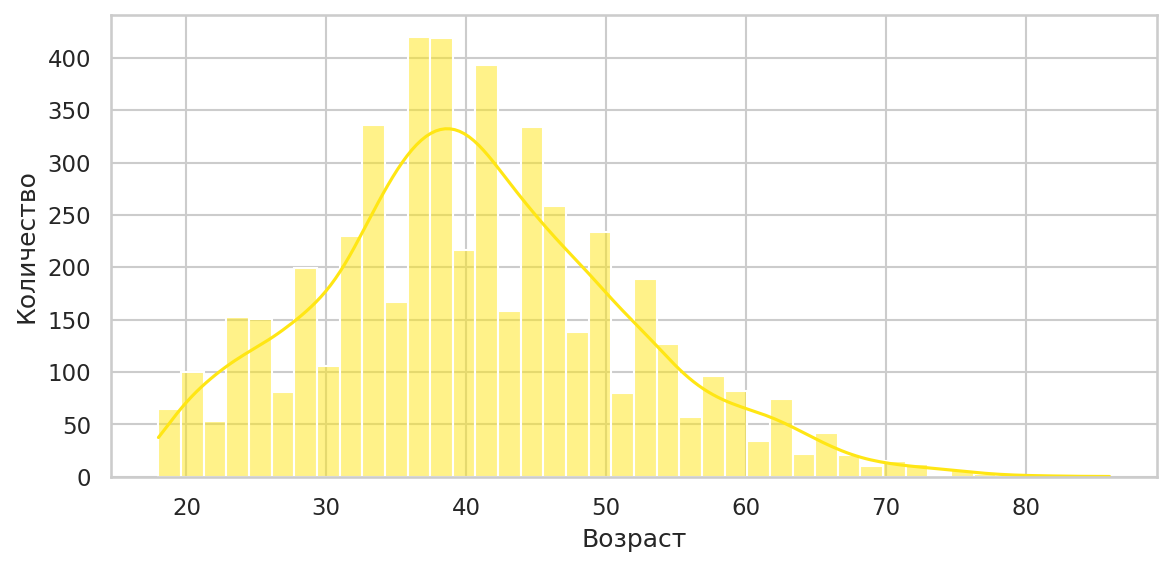

In [188]:
# Визуализируем распределение возраста по клиентам
sns.set_theme(style="whitegrid")

plt.figure(figsize=(9,4), dpi=150)
sns.histplot(user_df.age, kde=True, color="#FFE614")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.savefig("plot1.png", dpi=300, transparent=True)

plt.show()

In [147]:
user_df.age.describe()

,age
count,5091.000000
mean,40.532312
std,10.911822
min,18.000000
25%,33.000000
50%,40.000000
75%,47.000000
max,86.000000


In [148]:
user_df.shape

(5091, 22)

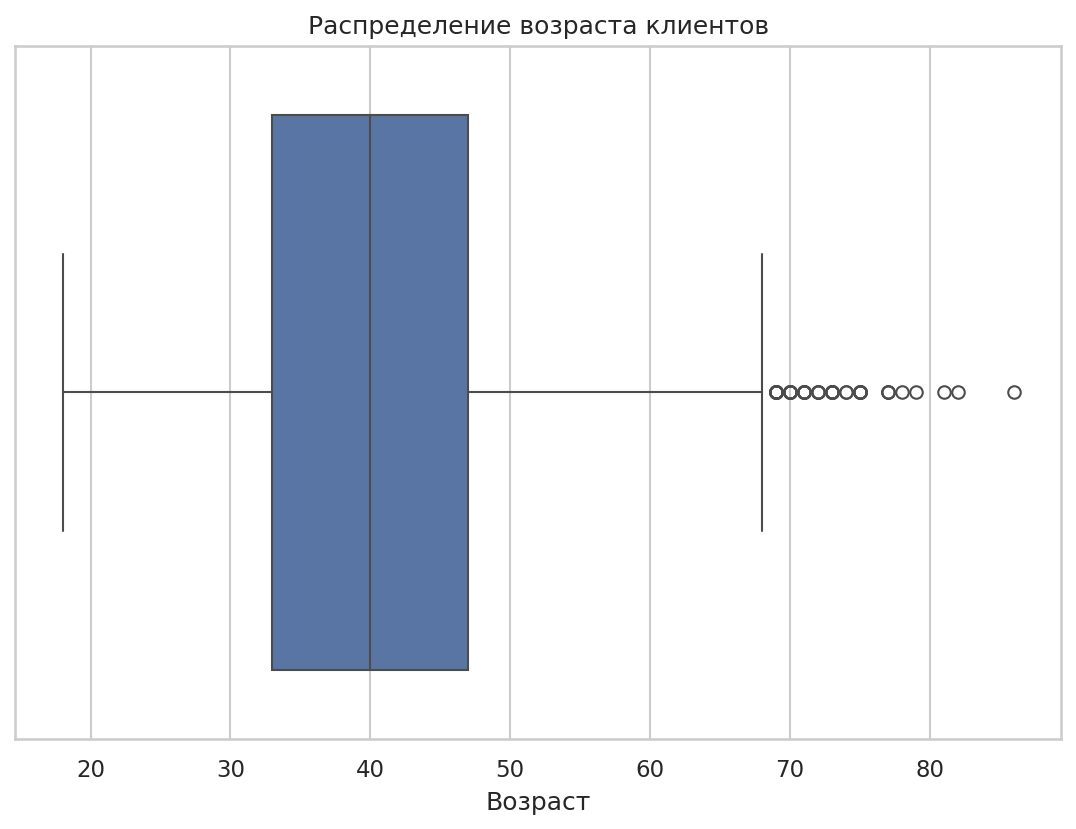

In [149]:
plt.figure(figsize=(9,6), dpi=150)
sns.boxplot(x=user_df["age"])

plt.title("Распределение возраста клиентов")
plt.xlabel("Возраст")
plt.show()

<Axes: xlabel='monthly_income_amt', ylabel='Count'>

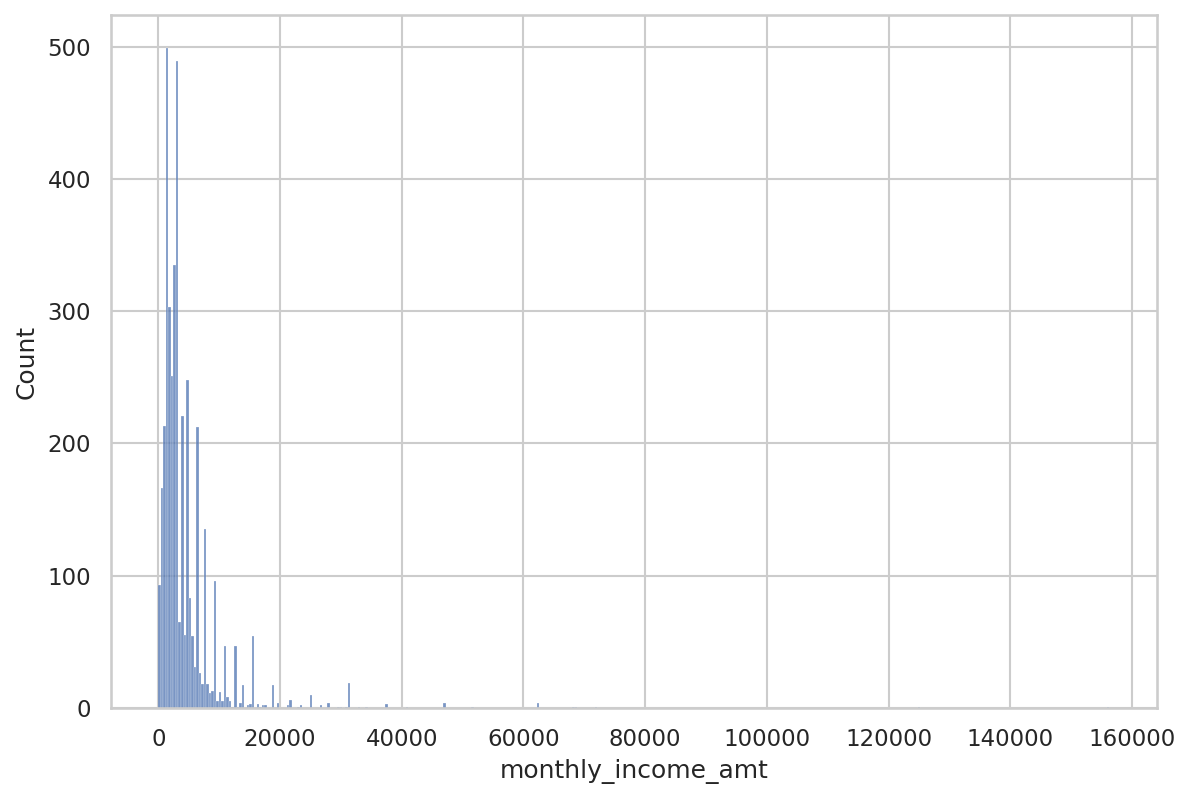

In [150]:
# Визуализируем распределение доходов по клиентам

plt.figure(figsize=(9,6), dpi=150)
sns.histplot(user_df.monthly_income_amt)

Видим 2 сильных выброса в зарплатах - для наглядности визуализации посмотрим на график без выбросов (используем межквартальный размах)

<Axes: xlabel='monthly_income_amt', ylabel='Count'>

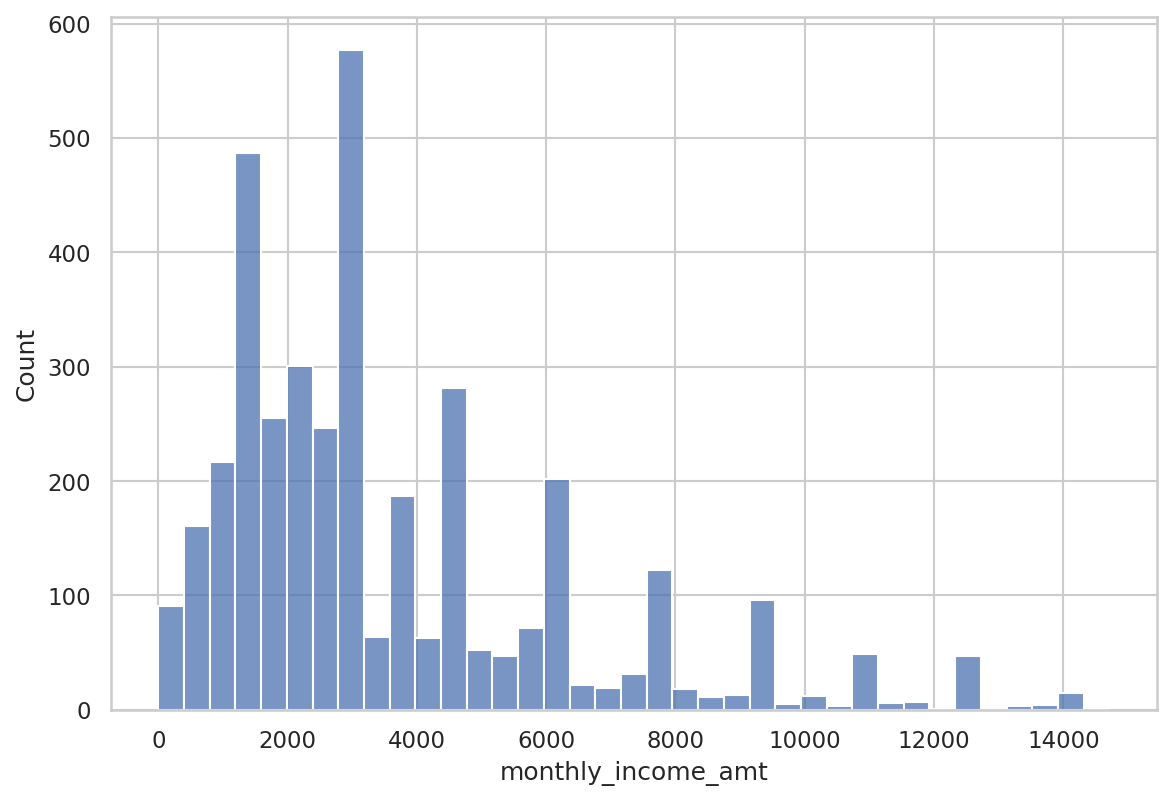

In [151]:
IQR = user_df["monthly_income_amt"].quantile(0.75) - user_df["monthly_income_amt"].quantile(0.25)
upper = user_df["monthly_income_amt"].quantile(0.75) + 3 * IQR
user_df_filter = user_df[user_df["monthly_income_amt"] < upper]

plt.figure(figsize=(9,6), dpi=150)
sns.histplot(user_df_filter.monthly_income_amt)

In [152]:
print(f"Но обратим внимание, что таким образом из {user_df["monthly_income_amt"].notna().sum()} -> {user_df_filter["monthly_income_amt"].notna().sum()} пользователей")
print(f"Отсекли {user_df["monthly_income_amt"].notna().sum() - user_df_filter["monthly_income_amt"].shape[0]} пользователей")

Но обратим внимание, что таким образом из 3944 -> 3789 пользователей
Отсекли 155 пользователей


Text(0.5, 0, 'log(monthly_income_amt)')

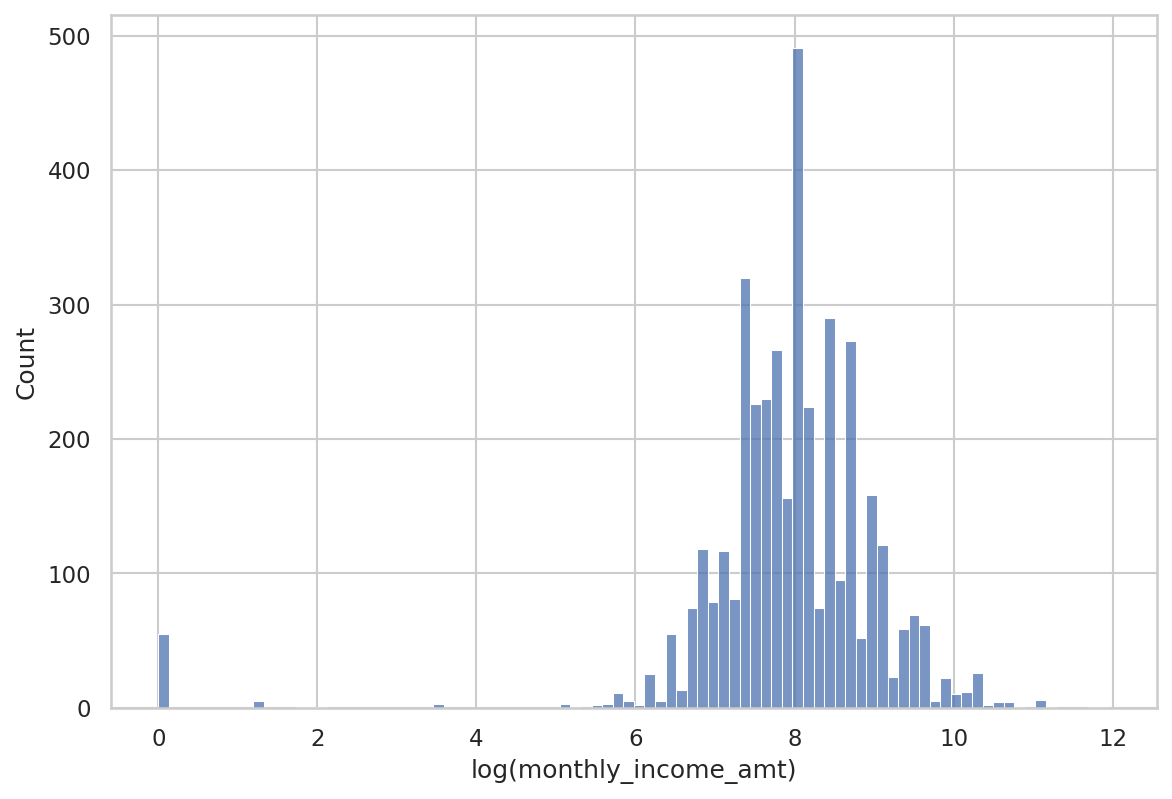

In [153]:
# Используем логарифмическую шкалу
plt.figure(figsize=(9,6), dpi=150)
sns.histplot(np.log1p(user_df["monthly_income_amt"]))
plt.xlabel("log(monthly_income_amt)")

(0.0, 1000000.0)

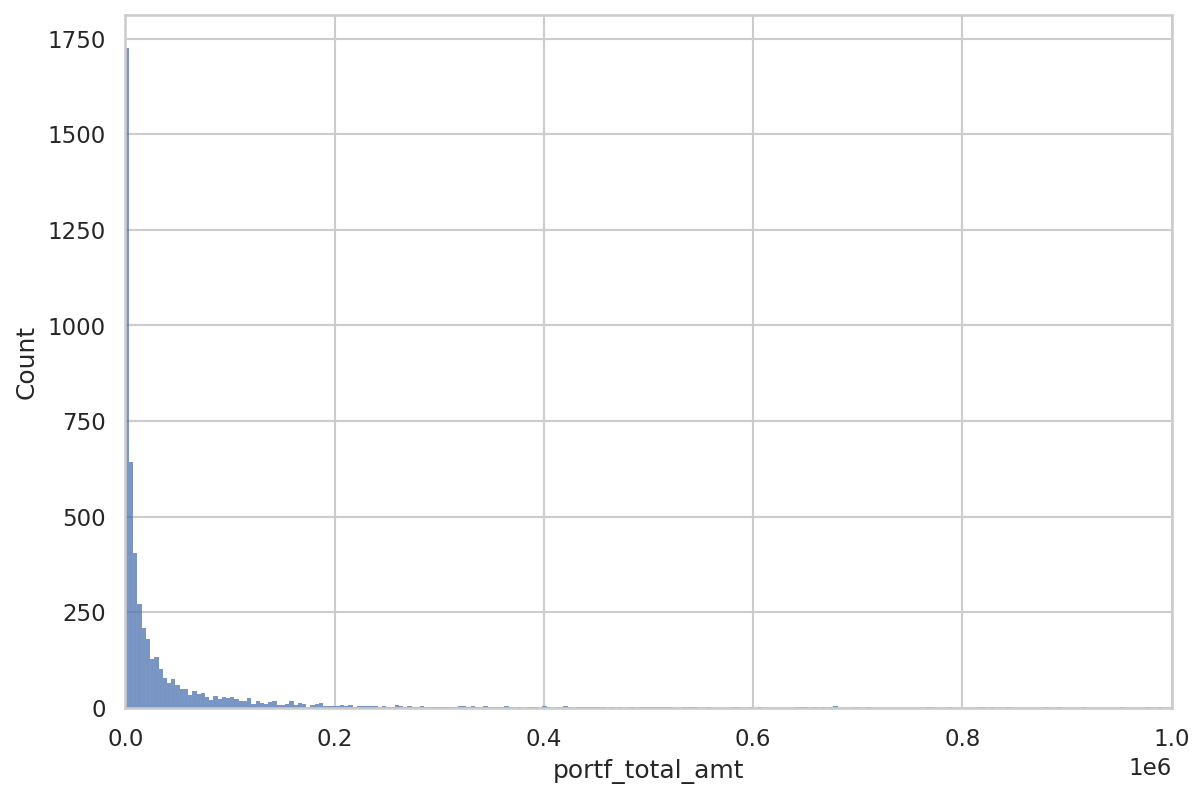

In [154]:
# Визуализируем распределение размера портфеля по клиентам

plt.figure(figsize=(9,6), dpi=150)
sns.histplot(user_df.portf_total_amt)
plt.xlim(0, 1_000_000) # отрезаем хвост

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'log(portf_total_amt)')

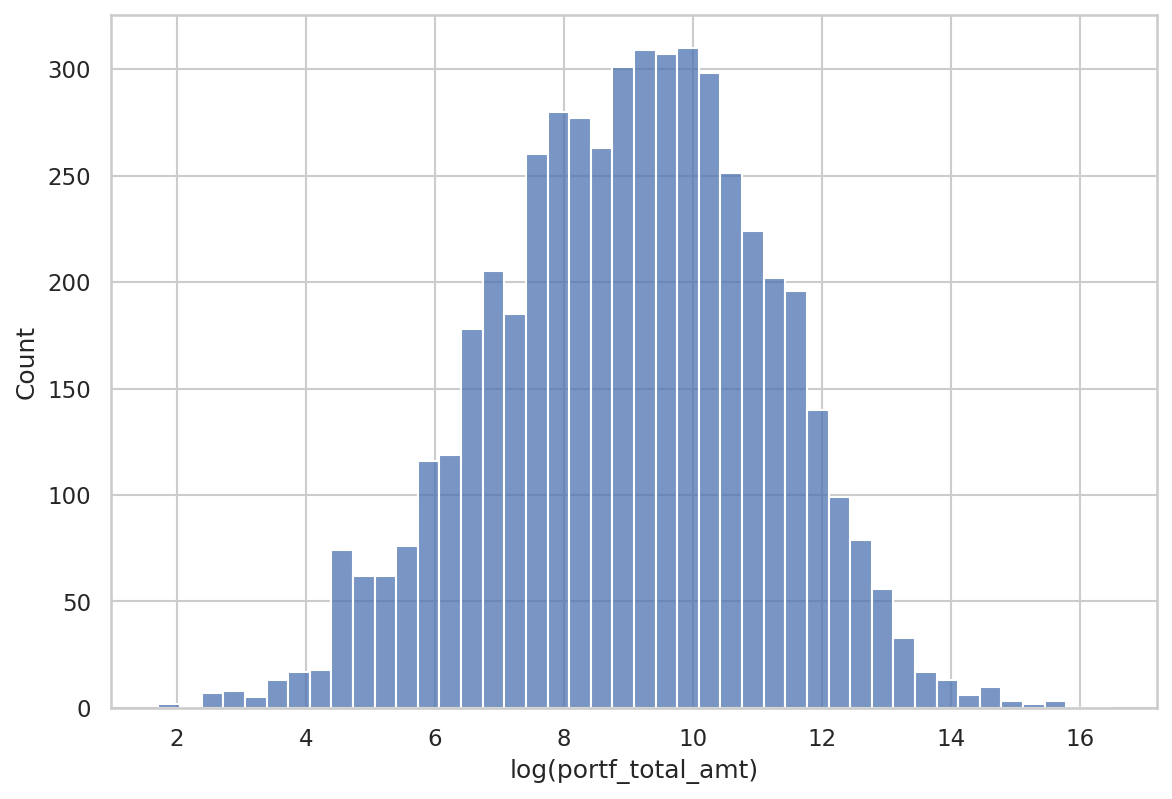

In [155]:
# Используем логарифмическую шкалу
plt.figure(figsize=(9,6), dpi=150)
sns.histplot(np.log1p(user_df["portf_total_amt"]))
plt.xlabel("log(portf_total_amt)")

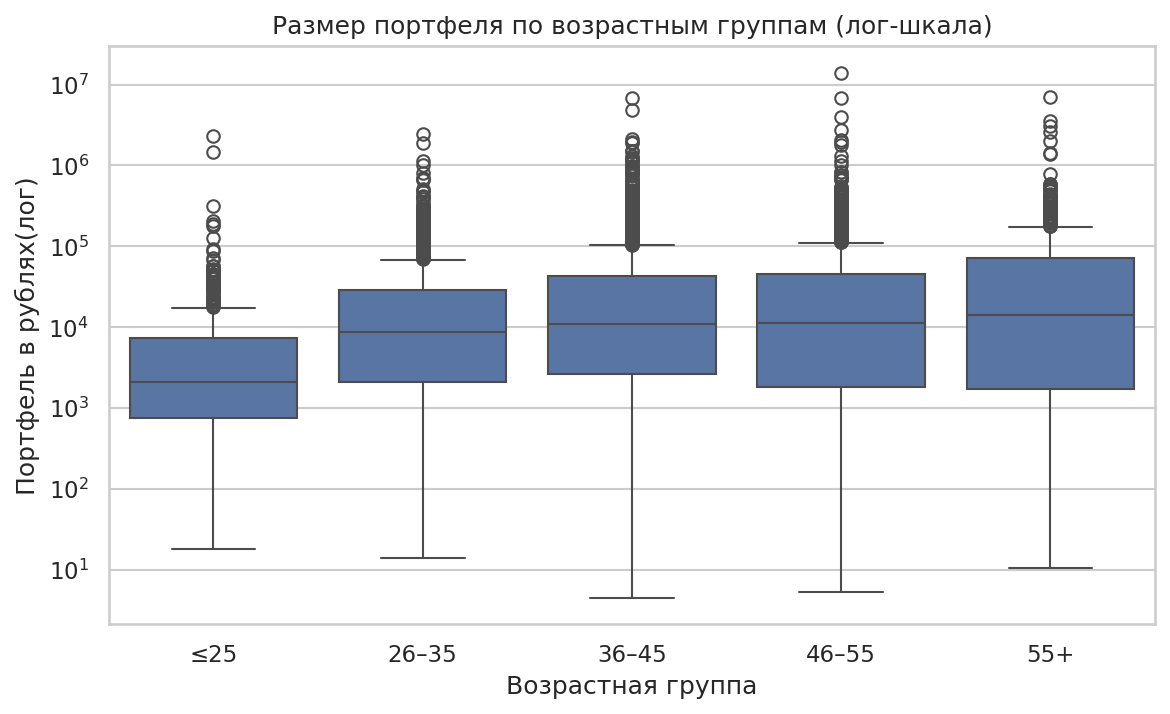

In [156]:
# Посмотрим на возрастные различия в портфелях

bins   = [0, 25, 35, 45, 55, 120]
labels = ['≤25','26–35','36–45','46–55','55+']
user_df['age_group'] = pd.cut(user_df['age'], bins=bins, labels=labels, include_lowest=True)

tmp = user_df[['age_group','portf_total_amt']].dropna()
tmp = tmp[tmp['portf_total_amt'] > 0]

plt.figure(figsize=(9,5), dpi=150)
sns.boxplot(data=tmp, x='age_group', y='portf_total_amt')
plt.yscale('log')
plt.title('Размер портфеля по возрастным группам (лог-шкала)')
plt.xlabel('Возрастная группа')
plt.ylabel('Портфель в рублях(лог)')

plt.show()

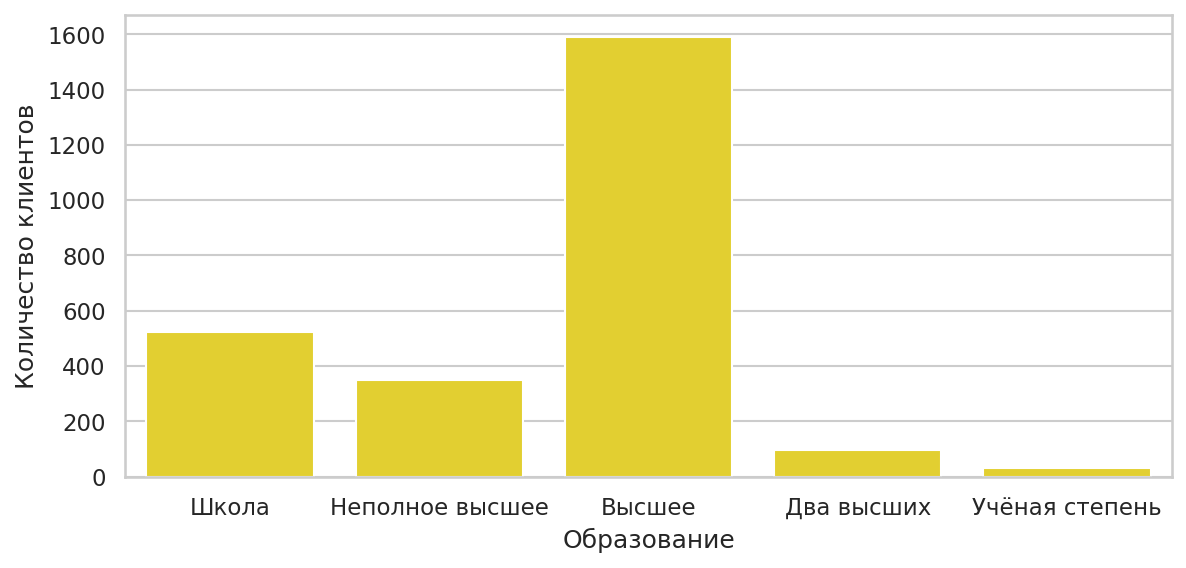

In [182]:
# Посмотрим категориальные признаки пользователя

# Образование
edu_map = {
    "SCH": "Школа",
    "UGR": "Неполное высшее",
    "GRD": "Высшее",
    "PGR": "Два высших",
    "ACD": "Учёная степень"
}
user_df["edu_name"] = user_df["education_level_cd"].map(edu_map)

order = ["Школа", "Неполное высшее", "Высшее", "Два высших", "Учёная степень"]

plt.figure(figsize=(9,4), dpi=150)
sns.countplot(data=user_df, x="edu_name", order=order, color="#FFE614")


plt.xlabel("Образование")
plt.ylabel("Количество клиентов")

plt.savefig("plot2.png", dpi=300, transparent=True)

plt.show()

In [158]:
# Посмторим на диверсификацию портфеля в зависимости от возроста/образования

assets = ["portf_rus_sec_amt","portf_rus_bon_amt","portf_etf_amt",
          "portf_fnd_amt","portf_opt_amt","portf_ore_amt","portf_cur_amt"]

X = df[assets].apply(pd.to_numeric, errors="coerce")

X_pos = X.abs()

totals = X_pos.sum(axis=1, skipna=True)
shares = X_pos.div(totals, axis=0)

df["HHI"] = (shares ** 2).sum(axis=1, skipna=True)
print(df["HHI"])

hhi_by_id = df.groupby("id")["HHI"].mean().reset_index()
user_df = user_df.merge(hhi_by_id, on="id", how="left")
user_df.head()

0         0.445797
1         0.496861
2         0.805205
3         1.000000
4         0.825728
            ...   
458365    0.569063
458366    0.577846
458367    0.471278
458368    0.926184
458369    0.451862
Name: HHI, Length: 457487, dtype: float64


,id,age,education_level_cd,marital_status_cd,children_cnt,monthly_income_amt,invest_utilization_dt,in_payment_rub_amt,out_payment_rub_amt,turnover_total_amt,...,qualified_investor_flg,portf_total_amt,posts,comments,reacts,reads,cashflow,age_group,edu_name,HHI
0,42390,36,SCH,DIV,1.0,NaN,2023-11-28,835.0,10277.0,195948.0,...,0,7566.07,0.0,0.0,0.0,118.0,-9442.0,36–45,Школа,0.787476
1,129326,37,SCH,MAR,0.0,5181.39,2023-02-06,43031.0,36057.0,2690320.0,...,1,3911.44,0.0,5.0,3.0,10307.0,6974.0,36–45,Школа,0.895548
2,185930,64,GRD,MAR,0.0,2712.80,2023-12-22,0.0,0.0,2813.0,...,0,269.54,0.0,0.0,0.0,0.0,0.0,55+,Высшее,0.522339
3,404940,61,None,None,0.0,1587.77,2023-03-07,0.0,0.0,38351.0,...,0,18932.63,0.0,0.0,0.0,0.0,0.0,55+,NaN,0.492082
4,1035537,40,None,None,0.0,NaN,2022-08-11,237.0,0.0,18438.0,...,0,1014.90,0.0,0.0,0.0,0.0,237.0,36–45,NaN,0.377796


/tmp/ipython-input-36774144.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = user_df_clean.pivot_table(


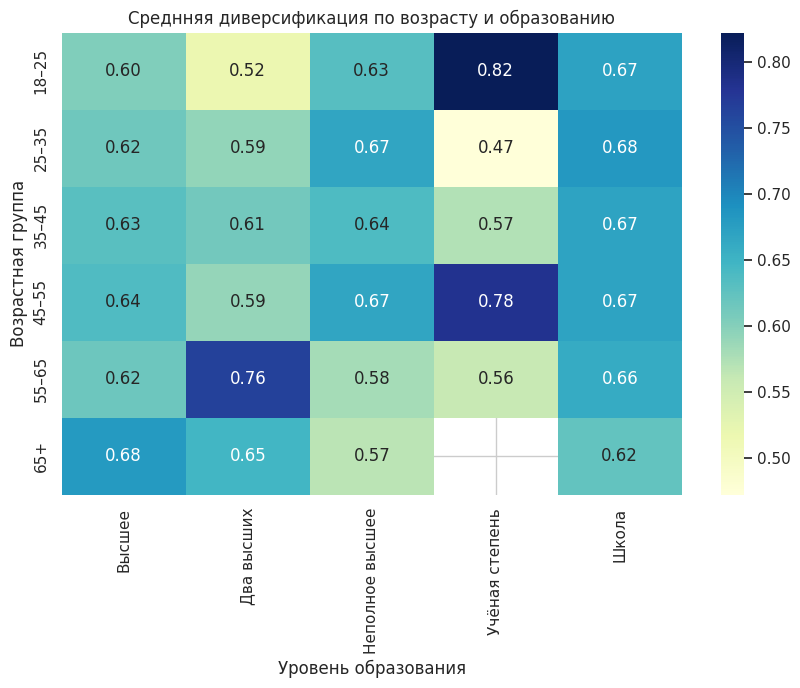

In [174]:
# Убираем ошибку в данных с образованием MGR
user_df_clean = user_df[user_df["education_level_cd"] != "MGR"].copy()

#Строим матрицу средней диверсификации по возрасту и образованию
# Для вычисления диверсификации используем индекс Херфиндаля

pivot = user_df_clean.pivot_table(
    index="age_group", columns="edu_name",
    values="HHI", aggfunc="mean"
)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Среднняя диверсификация по возрасту и образованию")
plt.xlabel("Уровень образования")
plt.ylabel("Возрастная группа")
plt.show()

/tmp/ipython-input-2291626787.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_age = user_df_clean.groupby("age_group")["HHI"].mean()


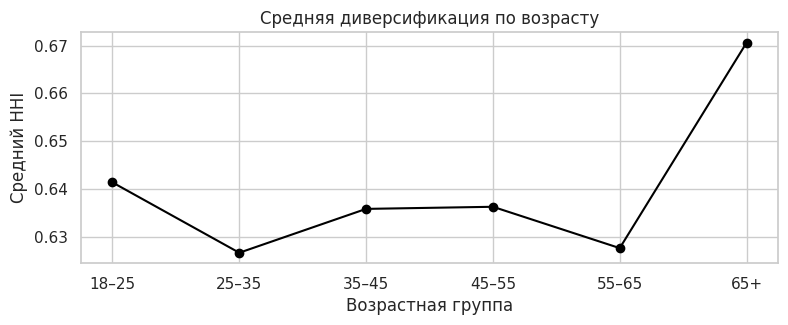

In [175]:
pivot_age = user_df_clean.groupby("age_group")["HHI"].mean()

plt.figure(figsize=(9,3))
plt.plot(pivot_age.index.astype(str), pivot_age.values, marker="o", color="black")
plt.title("Средняя диверсификация по возрасту")
plt.xlabel("Возрастная группа")
plt.ylabel("Средний HHI")

plt.savefig("plot3.png", dpi=300, transparent=True)

plt.show()


/tmp/ipython-input-858926469.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


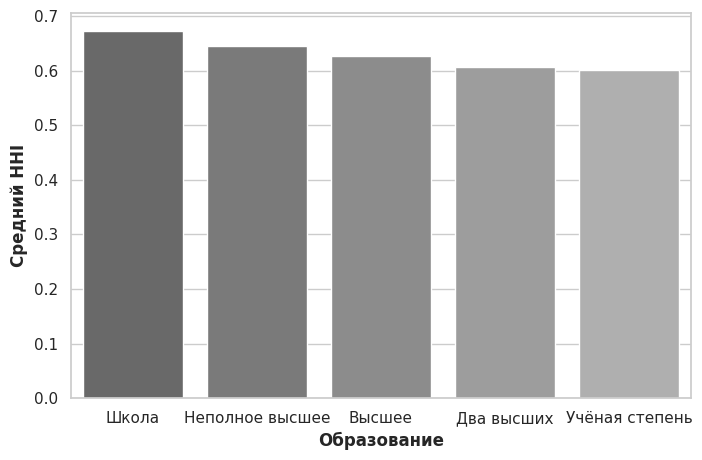

In [192]:
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list(
    "hhi_cmap", ["dimgrey", "silver"]
)

pivot_edu = user_df_clean.pivot_table(
    index="edu_name",
    values="HHI",
    aggfunc="mean").sort_values("HHI", ascending=False)

# генерируем цвета под количество категорий
custom_palette = [cmap(i/len(pivot_edu)) for i in range(len(pivot_edu))]

plt.figure(figsize=(8,5))
sns.barplot(
    x=pivot_edu.index,
    y=pivot_edu["HHI"],
    palette=custom_palette,
    order=pivot_edu.index
)

plt.xlabel("Образование", fontweight="bold")
plt.ylabel("Средний HHI", fontweight="bold")


plt.savefig("plot3.png", dpi=300, transparent=True)
plt.show()


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Холост/Не замужем'),
  Text(1, 0, 'Никогда не состоял(а) в браке'),
  Text(2, 0, 'Незарегистрированный брак'),
  Text(3, 0, 'Гражданский брак'),
  Text(4, 0, 'Зарегистрированный брак'),
  Text(5, 0, 'Женат/Замужем'),
  Text(6, 0, 'Не проживает с супругом(ой)'),
  Text(7, 0, 'Разведен(а)'),
  Text(8, 0, 'Вдовец/Вдова')])

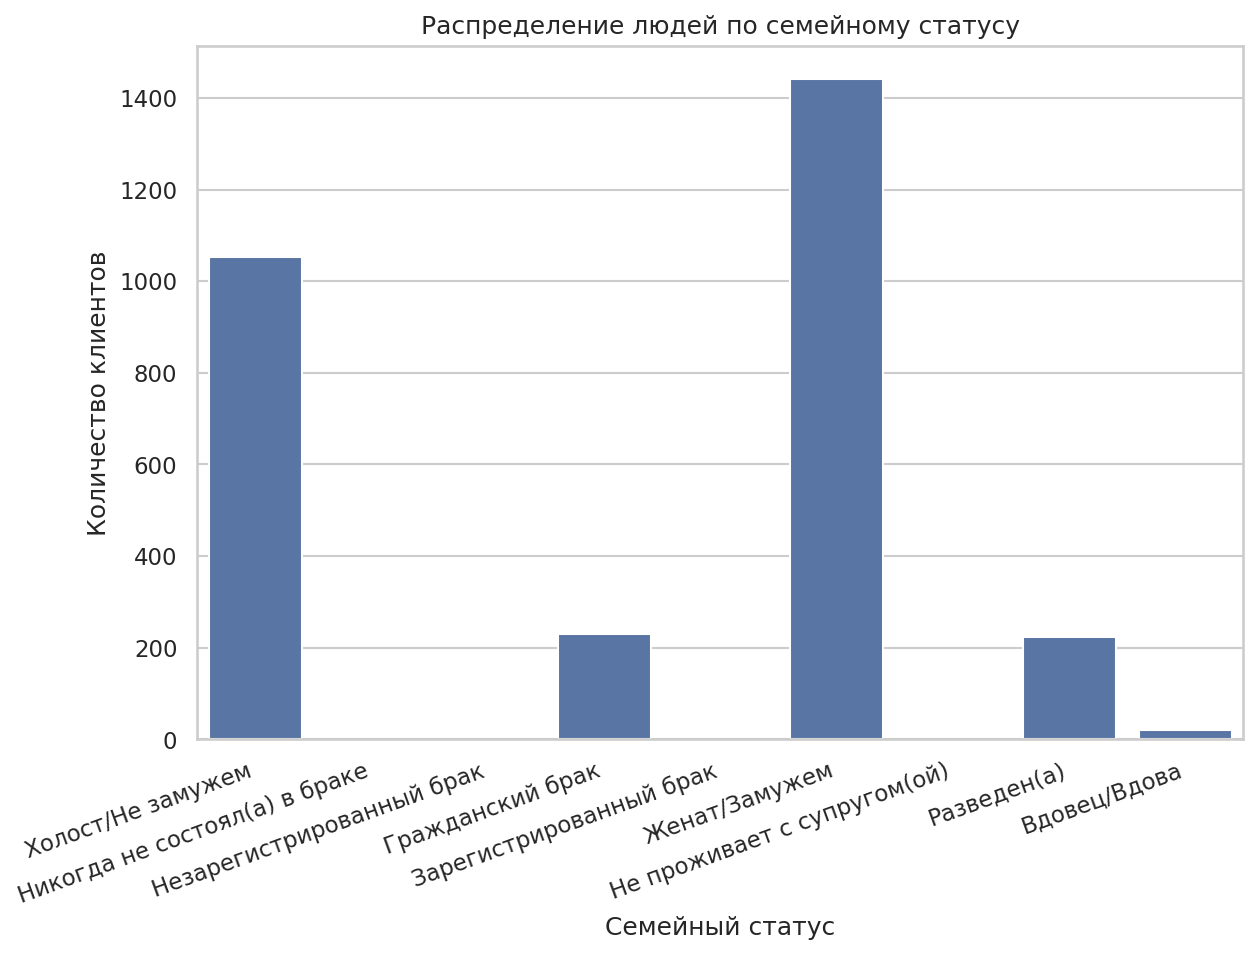

In [162]:
# Семейный статус
mar_map = {
    "IMR": "Незарегистрированный брак",
    "MAR": "Женат/Замужем",
    "DLW": "Не проживает с супругом(ой)",
    "OMR": "Зарегистрированный брак",
    "CIV": "Гражданский брак",
    "UNM": "Холост/Не замужем",
    "DIV": "Разведен(а)",
    "FAL": "Никогда не состоял(а) в браке",
    "WID": "Вдовец/Вдова"
}
user_df["mar_name"] = user_df["marital_status_cd"].map(mar_map)

mar_order = [
    "Холост/Не замужем",
    "Никогда не состоял(а) в браке",
    "Незарегистрированный брак",
    "Гражданский брак",
    "Зарегистрированный брак",
    "Женат/Замужем",
    "Не проживает с супругом(ой)",
    "Разведен(а)",
    "Вдовец/Вдова",
]

plt.figure(figsize=(9,6), dpi=150)
ax = sns.countplot(data=user_df, x="mar_name", order=mar_order)

ax.set_title("Распределение людей по семейному статусу")
ax.set_xlabel("Семейный статус")
ax.set_ylabel("Количество клиентов")
plt.xticks(rotation=20, ha="right")

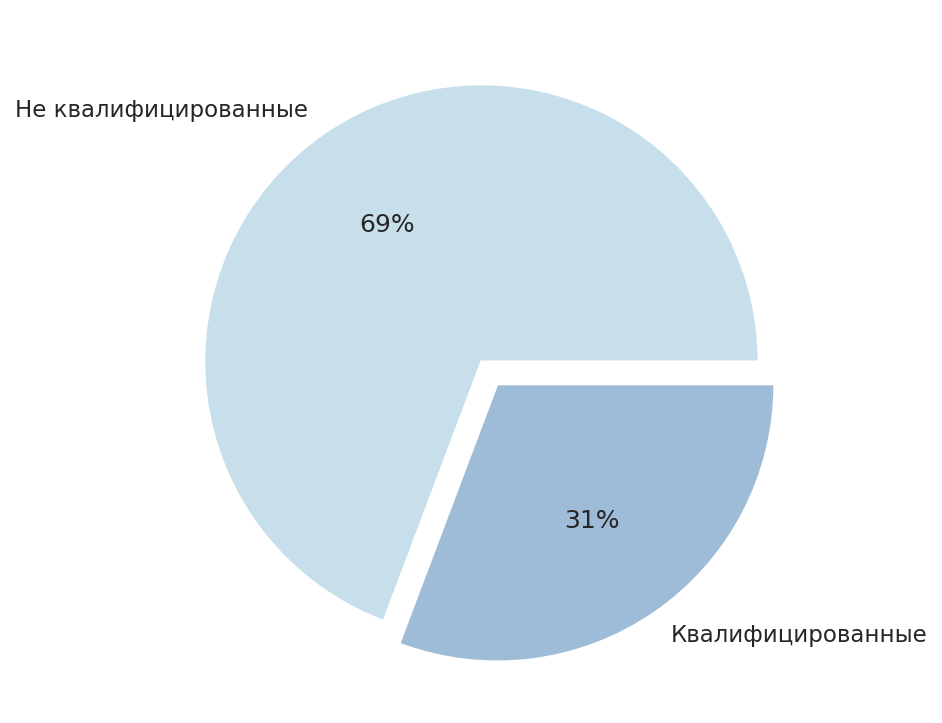

In [163]:
# Доля квалифицированных инвесторов

sns.set_theme(style="whitegrid", palette=sns.color_palette("ch:s=.25,rot=-.25", n_colors=6))
explode = [0, 0.1]

plt.figure(figsize=(9,6), dpi=150)
plt.pie(user_df["qualified_investor_flg"].value_counts(), labels=["Не квалифицированные", "Квалифицированные"], explode=explode, autopct='%.0f%%')
plt.show()

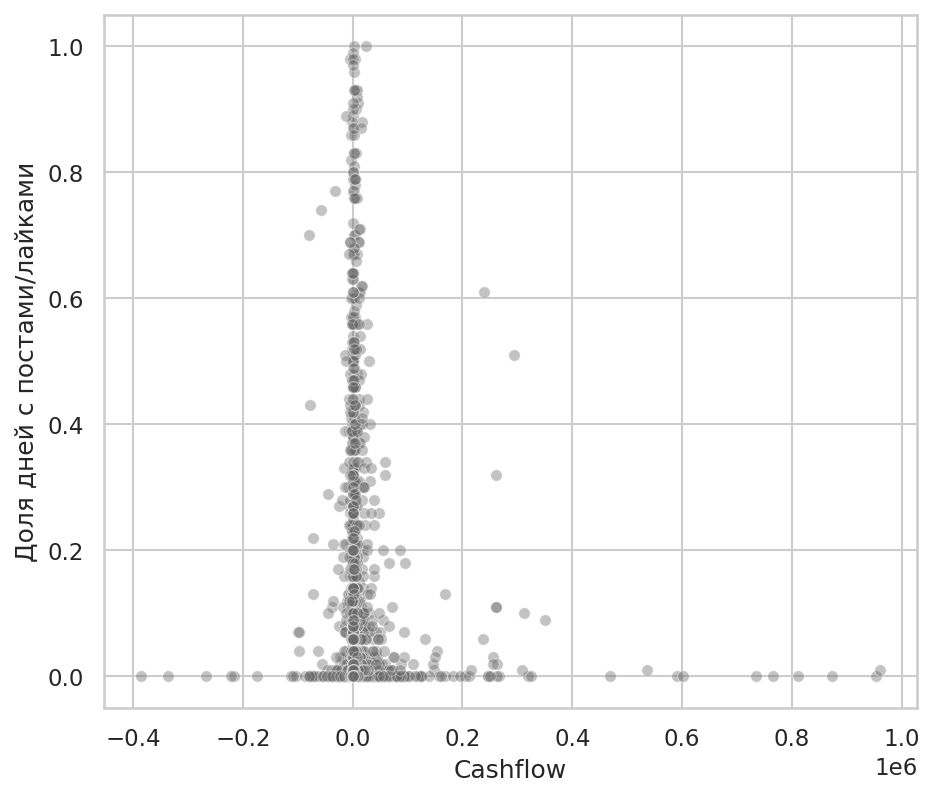

In [244]:
# Корреляция активности и социальной активности

# Убрали выброс
user_df_filter1 = user_df[user_df['cashflow'] < 1000000]

plt.figure(figsize=(7, 6), dpi=150)
sns.scatterplot(
    data=user_df_filter1,
    x="cashflow",
    y="social_activity",
    alpha=0.4,
    s=30, color="dimgrey"
)

# plt.title("Корреляция размера cashflow и активности в соц-сети")
plt.xlabel("Cashflow")
plt.ylabel("Доля дней с постами/лайками")

plt.savefig("plot3.png", dpi=300, transparent=True)
plt.show()


In [258]:
# Доля полностью неактивных пользователей в соцсети

user_df[user_df["social_activity"] < 0.03].shape[0] / user_df.shape[0]

0.8018071105873109

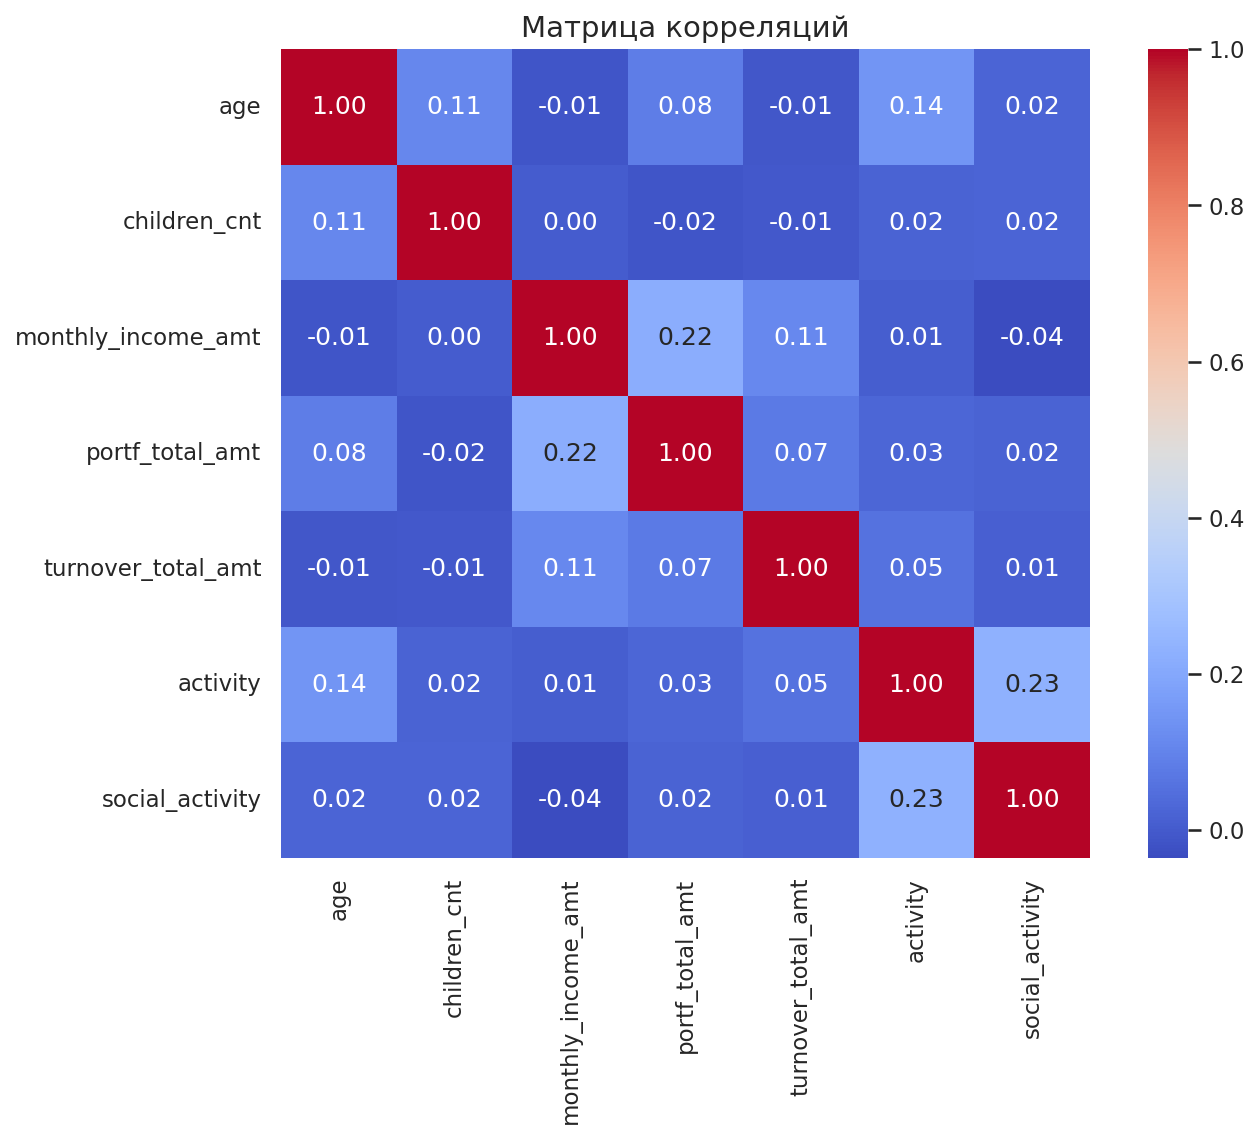

In [196]:
# Смотрим матрицу корреляций для основных характеристик
corr_cols = [
    "age",
    "children_cnt",
    "monthly_income_amt",
    "portf_total_amt",
    "turnover_total_amt",
    "activity",
    "social_activity"
]

# Считаем корреляцию
corr = user_df[corr_cols].corr()

plt.figure(figsize=(10, 7), dpi=150)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Матрица корреляций", fontsize=14)


plt.show()

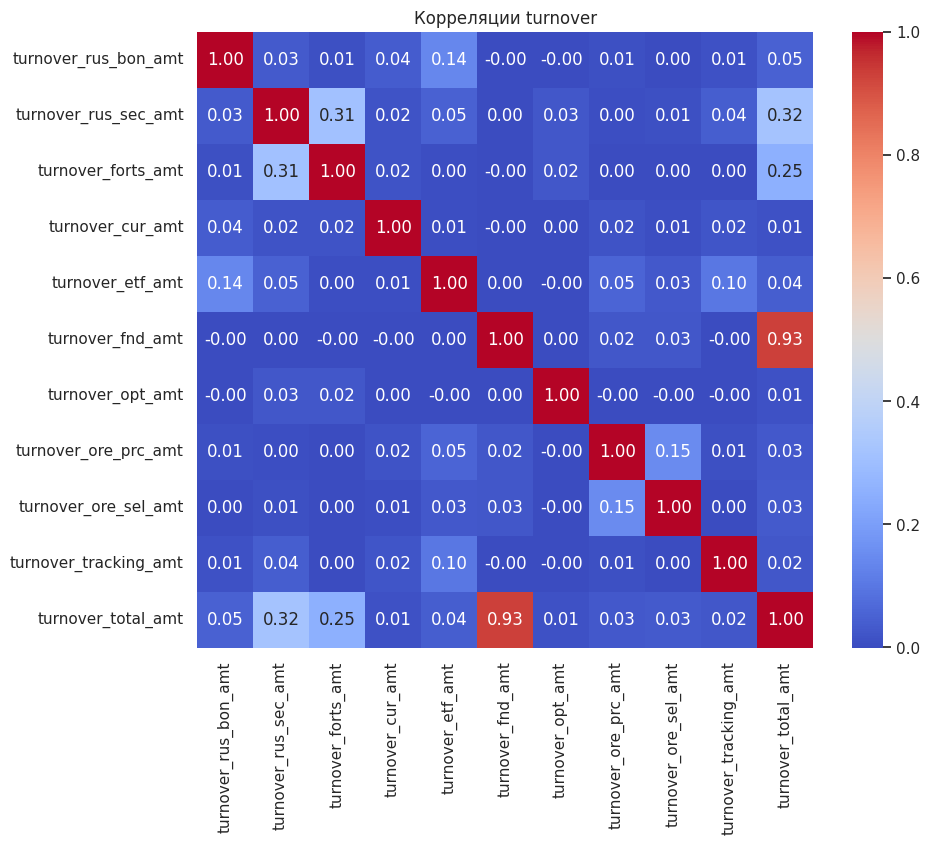

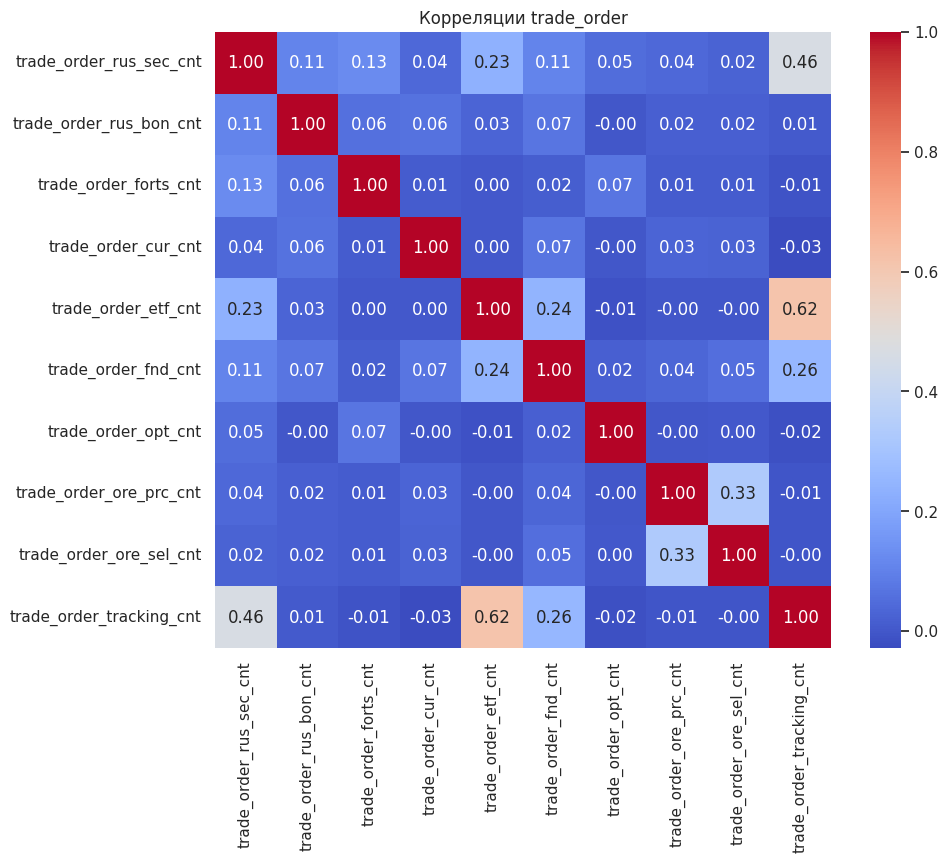

In [198]:
# Посмотрим корреляцию оборотов и кол-ва сделок
turnover_cols = [c for c in df.columns if c.startswith("turnover_")]
trade_cols = [c for c in df.columns if c.startswith("trade_order_")]

turnover_corr = df[turnover_cols].corr()
trade_corr = df[trade_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(turnover_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Корреляции turnover")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(trade_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Корреляции trade_order")
plt.show()



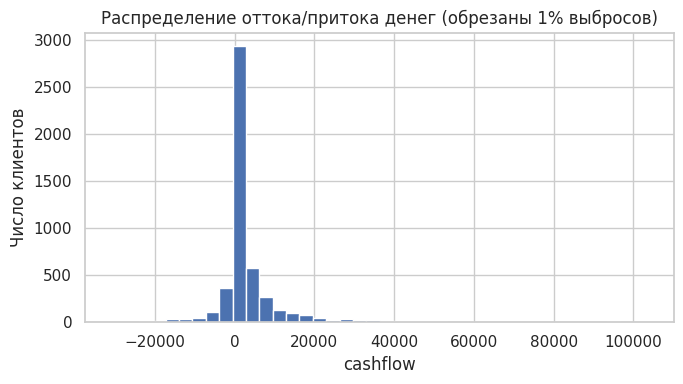

/tmp/ipython-input-1076883174.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_group")["cashflow"].mean())


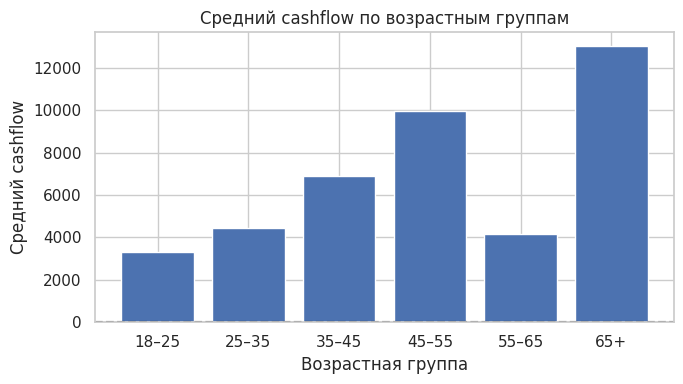

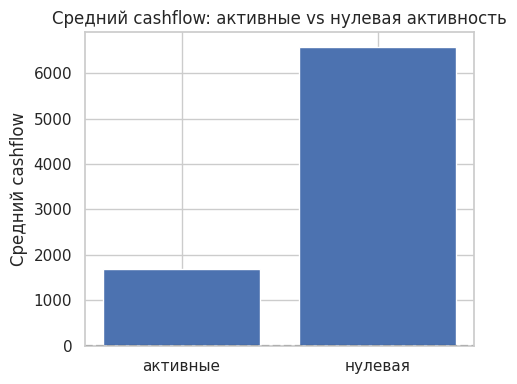

In [235]:
# Расммотрим подробнее cashflow

cash = user_df["cashflow"].astype(float).dropna()
low, high = cash.quantile([0.01, 0.99])   # уберём 1% крайних выбросов
cash_clip = cash[(cash>=low) & (cash<=high)]

plt.figure(figsize=(7,4))
plt.hist(cash_clip, bins=40)
plt.title("Распределение оттока/притока денег (обрезаны 1% выбросов)")
plt.xlabel("cashflow")
plt.ylabel("Число клиентов")
plt.tight_layout()
plt.show()


# Сгруппируем возраст
mean_age = (user_df.dropna(subset=["cashflow","age_group"])
             .groupby("age_group")["cashflow"].mean())

plt.figure(figsize=(7,4))
plt.bar(mean_age.index.astype(str), mean_age.values)
plt.axhline(0, linestyle="--", color="black")
plt.title("Средний cashflow по возрастным группам")
plt.xlabel("Возрастная группа")
plt.ylabel("Средний cashflow")
plt.tight_layout()
plt.show()


# Введем категории активных/неактивных пользователей в соцсети
user_df["soc_group"] = np.where(user_df["social_activity"]>0.7, "активные", "нулевая")


med_soc = (user_df.dropna(subset=["cashflow"])
             .groupby("soc_group")["cashflow"].mean())

plt.figure(figsize=(5,4))
plt.bar(med_soc.index, med_soc.values)
plt.axhline(0, linestyle="--", color="black")
plt.title("Средний cashflow: активные vs нулевая активность")
plt.ylabel("Средний cashflow")
plt.tight_layout()
plt.show()


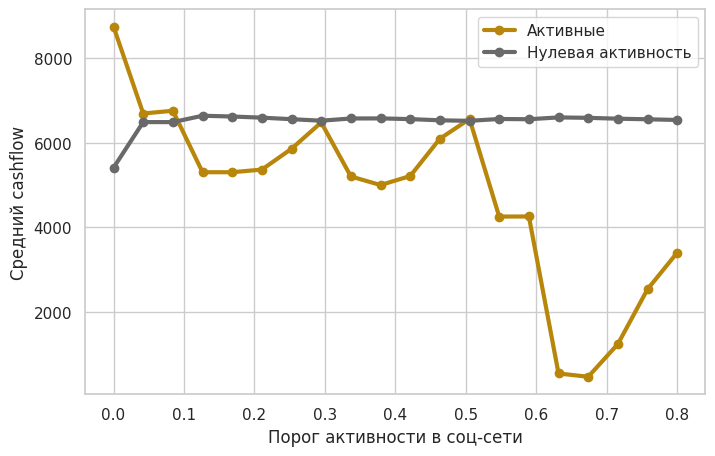

In [251]:
thresholds = np.linspace(0, 0.8, 20)
results = []

for t in thresholds:
    user_df["soc_group"] = np.where(user_df["social_activity"] > t, "активные", "нулевая")
    med_soc = (user_df.dropna(subset=["cashflow"])
                         .groupby("soc_group")["cashflow"].mean())
    results.append([t, med_soc.get("активные", np.nan), med_soc.get("нулевая", np.nan)])

res_df = pd.DataFrame(results, columns=["threshold", "active", "zero"])

# Рисуем динамику
plt.figure(figsize=(8,5))
plt.plot(res_df["threshold"], res_df["active"], marker="o", label="Активные", color="darkgoldenrod", linewidth=3)
plt.plot(res_df["threshold"], res_df["zero"], marker="o", label="Нулевая активность", color="dimgrey", linewidth=3)
# plt.title("Средний cashflow при разных порогах social_activity")
plt.xlabel("Порог активности в соц-сети")
plt.ylabel("Средний cashflow")
plt.legend()

plt.savefig("plot3.png", dpi=300, transparent=True)
plt.show()


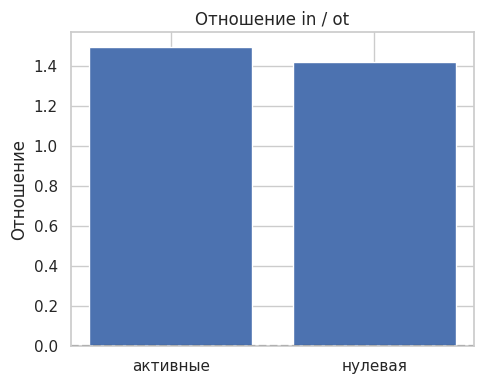

In [201]:
# Посмотрим на отношение in/out
med_soc_in_out = (user_df.dropna(subset=["in_payment_rub_amt"])
             .groupby("soc_group")["in_payment_rub_amt"].mean()) / (user_df.dropna(subset=["out_payment_rub_amt"])
             .groupby("soc_group")["out_payment_rub_amt"].mean())

plt.figure(figsize=(5,4))
plt.bar(med_soc_in_out.index, med_soc_in_out.values)
plt.axhline(0, linestyle="--", color="black")
plt.title("Отношение in / ot")
plt.ylabel("Отношение")
plt.tight_layout()
plt.show()


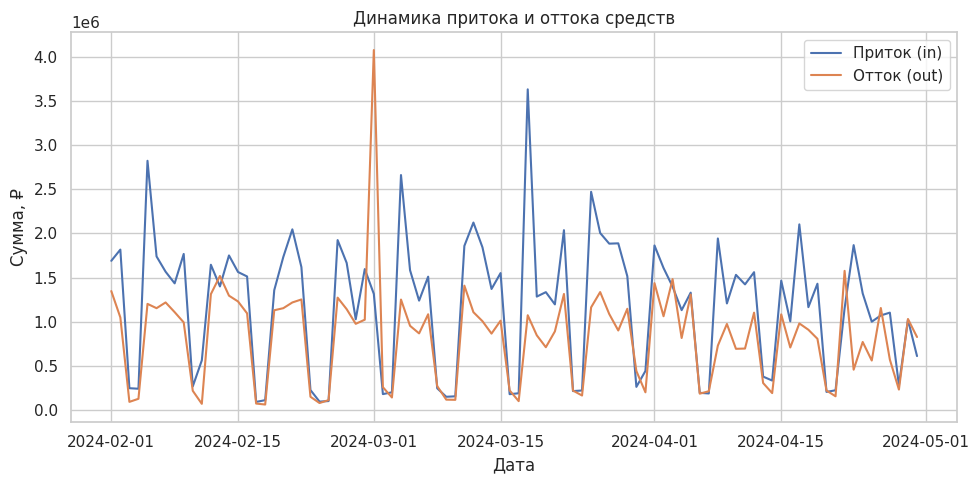

In [204]:
# Перейдем к временному ряду

# Динамика притока и оттока
plt.figure(figsize=(10,5))
plt.plot(daily_df["date"], daily_df["in_payment_rub_amt"], label="Приток (in)")
plt.plot(daily_df["date"], daily_df["out_payment_rub_amt"], label="Отток (out)")

plt.legend()
plt.title("Динамика притока и оттока средств")
plt.xlabel("Дата"); plt.ylabel("Сумма, ₽")
plt.tight_layout()
plt.show()



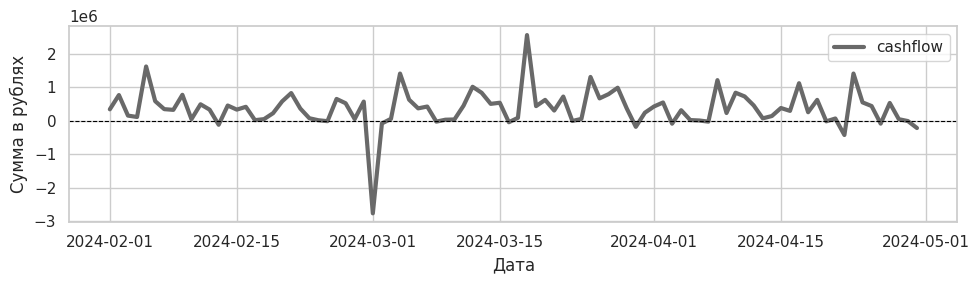

In [249]:
# Динамика cashflow
plt.figure(figsize=(10,3))

plt.plot(daily_df["date"], daily_df["cashflow"], label="cashflow", color="dimgrey", linewidth=3)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.legend()
plt.xlabel("Дата"); plt.ylabel("Сумма в рублях")
plt.tight_layout()

plt.savefig("plot3.png", dpi=300, transparent=True)
plt.show()

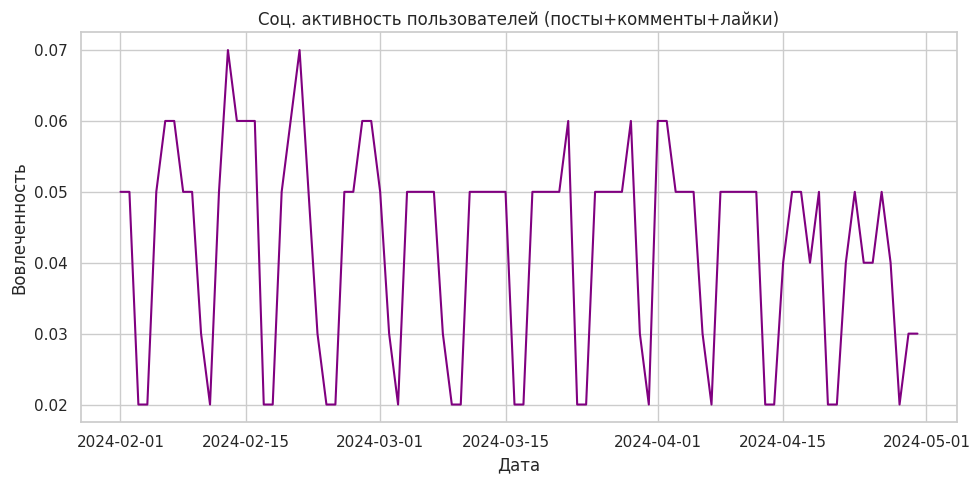

In [206]:
# Динамика активности пользователей

plt.figure(figsize=(10,5))
plt.plot(daily_df["date"], daily_df["social_activity"], color="purple")
plt.title("Соц. активность пользователей (посты+комменты+лайки)")
plt.xlabel("Дата"); plt.ylabel("Вовлеченность")
plt.tight_layout()
plt.show()


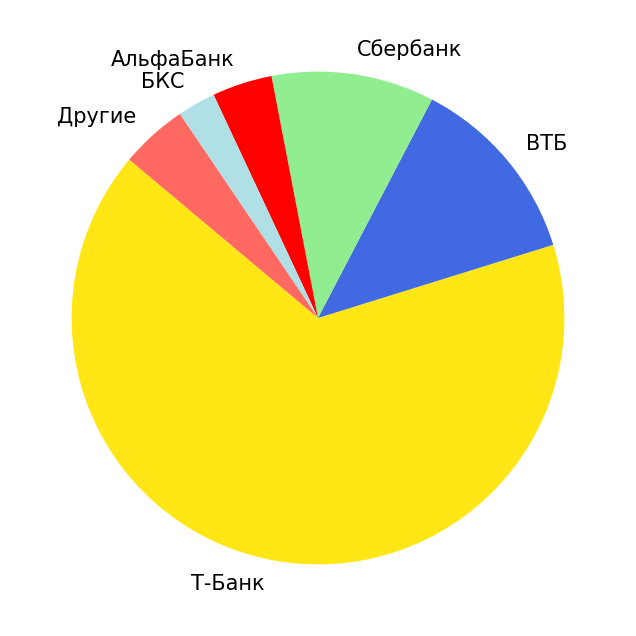

In [18]:
# Доля в рынке

banks = {"Т-Банк": 1879955,
         "ВТБ": 357972,
         "Сбербанк": 304496,
         "АльфаБанк": 112342,
         "БКС": 71681,
         "открытие": 52700,
         "Финам": 45208,
         "ЦиFра": 10488,
         "Газпромбанк": 9242,
         "Промсвязьбанк": 8199}

import matplotlib.pyplot as plt

colors = ["#FFE614",
          "royalblue", "lightgreen", "red", "powderblue",
          "#FF6961", "#FDFD96", "#B39EB5", "#779ECB", "#966FD6"]

filtered_banks = {k: v for k, v in banks.items() if k in ["Т-Банк", "ВТБ", "Сбербанк", "АльфаБанк", "БКС", "Открытие"]}
filtered_banks["Другие"] = sum(v for k, v in banks.items() if k not in filtered_banks)

plt.figure(figsize=(8, 8))
plt.pie(
    filtered_banks.values(),
    labels=filtered_banks.keys(),
    startangle=140,
    colors=colors,
    textprops={'fontsize': 15}
)

plt.savefig("plot3.png", dpi=300, transparent=True)

plt.show()
